# Dataset exploration

In this notebook the exploration required for task 3 will be described.

In [1]:
display(client.cluster)

NameError: name 'client' is not defined

In [22]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import csv
from pyarrow import dataset as ds
import os
import numpy as np
import pandas as pd


import dask_jobqueue
import dask
import dask.dataframe as dd
import time

from distributed import Client
from contextlib import suppress 
import platform

PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/"
CSV_PATH = "/d/hpc/projects/FRI/bigdata/data/NYTickets"
PARQUET_FILENAME = "entire_1.parquet"
PARQUET_PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/parquet_aug"
DATA_AUG_PATH = "/d/hpc/home/mf4782/BD_project/data/"

files = os.listdir(CSV_PATH)
files = list([f for f in files if ".csv" in f])
files.sort()
print(files)

['2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv', '2020.csv', '2021.csv', '2022.csv']


In [3]:
with suppress(Exception):
    client.shutdown()

cluster = dask_jobqueue.SLURMCluster(
            queue = 'all', 
            processes=1,
            cores=32, 
            memory='32GB',
            scheduler_options={'dashboard_address': ':21722'},
            death_timeout=120, # seconds
            walltime="1-01:30",
          )

client = Client(cluster, timeout="120s")#, memory_limit='8GB')
display(client.cluster)

In [4]:
client.cluster.scale(16)
display(client.cluster)

In [50]:
client.shutdown()

In [53]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Issue Date', 'Vehicle Body Type', "Violation Location"])
df['Date']=dd.to_datetime(df['Issue Date'])
df['Weekday'] = df['Date'].dt.day_name()

CPU times: user 27 ms, sys: 5.97 ms, total: 32.9 ms
Wall time: 33.8 ms


In [184]:
files = os.listdir(CSV_PATH)
files = list([f for f in files if ".csv" in f])
files.sort()
print(files)

['2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv', '2020.csv', '2021.csv', '2022.csv']


In [92]:
column_types = {
"Summons Number" : pa.int64(),                     
"Plate ID" : pa.string(),                           
"Registration State" : pa.string(),                 
"Plate Type" : pa.string(),                         
"Issue Date" : pa.string(),                         
"Violation Code" : pa.int64(),                      
"Vehicle Body Type" : pa.string(),                  
"Vehicle Make" : pa.string(),                       
"Issuing Agency" : pa.string(),                     
"Street Code1" : pa.int64(),                        
"Street Code2" : pa.int64(),                        
"Street Code3" : pa.int64(),                                  
"Vehicle Expiration Date" : pa.string(),            
"Violation Location" : pa.int64(),                  
"Violation Precinct" : pa.int64(),                  
"Issuer Precinct" : pa.int64(),                     
"Issuer Code" : pa.int64(),                         
"Issuer Command" : pa.string(),                     
"Issuer Squad" : pa.string(),                       
"Violation Time" : pa.string(),                     
"Time First Observed" : pa.string(),                
"Violation County" : pa.string(),                   
"Violation In Front Of Or Opposite" : pa.string(),  
"Number" : pa.string(),                             
"House Number" : pa.string(),                       
"Street" : pa.string(),                             
"Street Name" : pa.string(),                        
"Intersecting Street" : pa.string(),                
"Date First Observed" : pa.string(),                
"Law Section" : pa.int64(),                         
"Sub Division" : pa.string(),                       
"Violation Legal Code" : pa.string(),               
"Days Parking In Effect    " : pa.string(),         
"From Hours In Effect" : pa.string(),               
"To Hours In Effect" : pa.string(),                 
"Vehicle Color" : pa.string(),                      
"Unregistered Vehicle?" : pa.string(),               
"Vehicle Year" : pa.int64(),                        
"Meter Number" : pa.string(),                       
"Feet From Curb" : pa.int64(),                      
"Violation Post Code" : pa.string(),                
"Violation Description" : pa.string(),              
"No Standing or Stopping Violation" : pa.string(),  
"Hydrant Violation" : pa.string(),                  
"Double Parking Violation" : pa.string(),
'Days Parking In Effect': pa.string()}  
col_types_2 = {k: object for k in column_types}

In [ ]:
s = set()
for f in files:
    df = dd.read_csv("/d/hpc/projects/FRI/bigdata/data/NYTickets/" + f, dtype=col_types_2)
    print(df.columns)
    print(len(df.columns))
    s.update(list(df.columns.values))
    print("=====")
print(len(s))

new_cols = {}
for f in files:
    df = dd.read_csv("/d/hpc/projects/FRI/bigdata/data/NYTickets/" + f, dtype=col_types_2)
    new_cols[f] = list(s - set(df.columns.values))
print(new_cols)

In [88]:
col_types = {k: object for k in s}
print(col_types)

{'From Hours In Effect': <class 'object'>, 'No Standing or Stopping Violation': <class 'object'>, 'Violation Time': <class 'object'>, 'Street': <class 'object'>, 'Street Code3': <class 'object'>, 'Vehicle Color': <class 'object'>, 'Violation County': <class 'object'>, 'Intersecting Street': <class 'object'>, 'Vehicle Year': <class 'object'>, 'Vehicle Expiration Date': <class 'object'>, 'Summons Number': <class 'object'>, 'Days Parking In Effect    ': <class 'object'>, 'Date First Observed': <class 'object'>, 'Law Section': <class 'object'>, 'Sub Division': <class 'object'>, 'Street Name': <class 'object'>, 'Hydrant Violation': <class 'object'>, 'Issue Date': <class 'object'>, 'Unregistered Vehicle?': <class 'object'>, 'Issuer Squad': <class 'object'>, 'Issuer Precinct': <class 'object'>, 'Feet From Curb': <class 'object'>, 'Days Parking In Effect': <class 'object'>, 'Time First Observed': <class 'object'>, 'Issuing Agency': <class 'object'>, 'Meter Number': <class 'object'>, 'Violation

In [91]:
l = set([k for k in column_types])
s = set(s)
print(s - l)

{'Days Parking In Effect'}


In [89]:
dfs = []
for f in files:
    df = dd.read_csv("/d/hpc/projects/FRI/bigdata/data/NYTickets/" + f, dtype=col_types_2).persist()
    for col in new_cols[f]:
        df[col] = None
    dfs.append(df)

df = dd.concat(dfs).persist()

In [94]:
column_types_pa = {k: pa.string() for k in column_types}
df.to_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet', engine="pyarrow", compute=True, schema = column_types_pa)

[None]

In [11]:
df = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet').persist()
df

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,Number,Street,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,House Number,Street Name,Days Parking In Effect
npartitions=311,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
t = ds.dataset(CSV_PATH+"/"+files[0], format=custom_csv_format).to_table()
col_names = t.column_names
t = drop_cols_parquet(t)

s = time.time()
for f in files[1:]:
    tmp = ds.dataset(CSV_PATH+"/"+f, format=custom_csv_format).to_table()
    tmp = tmp.rename_columns(col_names)
    tmp = drop_cols_parquet(tmp)
    t = pa.concat_tables([t, tmp])
    print(time.time()-s)
pq.write_table(t, '/d/hpc/projects/FRI/bigdata/students/mfmt/parquet/data_*.parquet')

## Data Augmentation

In [141]:
dtype={'BIKE_TRAFD': 'object',
       'L_HIGH_HN': 'object',
       'L_LOW_HN': 'object',
       'POST_DIREC': 'object',
       'POST_MODIF': 'object',
       'PRE_MODIFI': 'object',
       'PRE_TYPE': 'object',
       'R_HIGH_HN': 'object',
       'R_LOW_HN': 'object'}

geo_df = dd.read_csv(DATA_AUG_PATH + "geo_location.csv", assume_missing=True, dtype=dtype)

In [145]:
def str_mean(l):
    n = len(l)
    s = 0
    for i in range(n):
        try:
            s = s +  float(l[i])
        except:
            pass
    if n == 0:
        return 0
    return s / n

def get_long(row):
    loc = row["the_geom"].replace("MULTILINESTRING ((","").replace(")","").replace(",","").split(" ")
    lgs = loc[0::2]
    return str_mean(lgs)

def get_lat(row):
    loc = row["the_geom"].replace("MULTILINESTRING ((","").replace(")","").replace(",","").split(" ")
    lat = loc[1::2]
    return str_mean(lat)

In [146]:
geo_df["Lattitude"] = geo_df.apply(get_lat, axis = 1, result_type="expand")
geo_df["Longitude"] = geo_df.apply(get_long, axis = 1, result_type="expand")
geo_df = geo_df.persist()


/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/dask/dataframe/core.py:4959: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [147]:
def get_closest_street(row):
    df = df_curr
    col = curr_col
    street_name = ""
    df["dist"] = (row["Lattitude"] - df["Lattitude"])**2 + (row["Longitude"] - df["Longitude"])**2
    r = df[df["dist"] == min(df["dist"])]
    print(r)
    return r[col].values[0]

### PoI Dataset

In [148]:
df_poi = pd.read_csv(DATA_AUG_PATH + "attraction.csv")

In [149]:
lats = []
longs = []
seg_ids = []
names = []

for i, k in df_poi.iterrows():
    loc = k["the_geom"].replace("POINT (","").replace(")","").split(" ")
    lats.append(float(loc[1]))
    longs.append(float(loc[0]))
    seg_ids.append(int(k["SEGMENTID"]))
    names.append(k["NAME"])

    
data = {"Lattitude": lats, "Longitude": longs, "Segment ID":seg_ids, "Name":names}
#print(data)
df_poi = pd.DataFrame(data=data)

In [150]:
df_curr = df_poi
curr_col = "Name"
geo_df["PoI"] = geo_df.apply(get_closest_street, axis = 1, result_type="expand").persist()

       Lattitude  Longitude  Segment ID                              Name  \
11223  40.594469 -73.735445      182731  BANNISTER CREEK ENTRANCE BUOY 2A   

              dist  
11223  7153.108728  
       Lattitude  Longitude  Segment ID                              Name  \
11223  40.594469 -73.735445      182731  BANNISTER CREEK ENTRANCE BUOY 2A   

              dist  
11223  7153.108728  


/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/dask/dataframe/core.py:4959: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [152]:
%%time
df_c = geo_df.compute()

CPU times: user 20.1 s, sys: 6.96 s, total: 27.1 s
Wall time: 13min 30s


In [154]:
df_c.iloc[100]

the_geom      MULTILINESTRING ((-74.0115498104063 40.7049507...
PHYSICALID                                                139.0
L_LOW_HN                                                     35
L_HIGH_HN                                                    59
R_LOW_HN                                                     32
R_HIGH_HN                                                    58
L_ZIP                                                   10004.0
R_ZIP                                                   10004.0
L_BLKFC_ID                                          212260348.0
R_BLKFC_ID                                          212261434.0
ST_LABEL                                              BEAVER ST
STATUS                                                      2.0
BIKE_LANE                                                   NaN
BOROCODE                                                    1.0
ST_WIDTH                                                   22.0
CREATED                                 

### School Dataset

In [155]:
df_school = pd.read_csv(DATA_AUG_PATH + "school.csv")

In [156]:
lats = []
longs = []
descs = []
names = []
for i, k in df_school.iterrows():
    try:
        loc = k["Location 1"].split("\n")[2].replace("(","").replace(")","").split(", ")
        lats.append(float(loc[0]))
        longs.append(float(loc[1]))
        names.append(k["LOCATION_NAME"])
        descs.append(k["LOCATION_CATEGORY_DESCRIPTION"])
    except:
        pass

    
data = {"Lattitude": lats, "Longitude": longs, "Name":names, "Type":descs}
df_school = pd.DataFrame(data=data)
df_school.head(5)

,Lattitude,Longitude,Name,Type
0,40.722075,-73.978747,P.S. 015 Roberto Clemente,Elementary
1,40.730009,-73.984496,P.S. 019 Asher Levy,Elementary
2,40.721305,-73.986312,P.S. 020 Anna Silver,Elementary
3,40.726008,-73.975058,P.S. 034 Franklin D. Roosevelt,K-8
4,40.724440,-73.986214,The STAR Academy - P.S.63,Elementary


In [157]:
df_elem = df_school[df_school["Type"] == "Elementary"]
df_curr = df_elem
curr_col = "Name"
geo_df["Elementary"] = geo_df.apply(get_closest_street, axis = 1, result_type="expand").persist()

      Lattitude  Longitude                               Name        Type  \
1802        0.0        0.0  Storefront Academy Charter School  Elementary   

      dist  
1802   2.0  
      Lattitude  Longitude                               Name        Type  \
1802        0.0        0.0  Storefront Academy Charter School  Elementary   

      dist  
1802   2.0  


/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/dask/dataframe/core.py:4959: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [159]:
df_high = df_school[df_school["Type"] == "High school"]
df_curr = df_high
curr_col = "Name"
geo_df["High School"] = geo_df.apply(get_closest_street, axis = 1, result_type="expand").persist()

      Lattitude  Longitude                                               Name  \
1288  40.601537 -73.763995          Frederick Douglass Academy VI High School   
1293  40.601537 -73.763995  Queens High School for Information, Research, and   

             Type         dist  
1288  High school  7157.936681  
1293  High school  7157.936681  
      Lattitude  Longitude                                               Name  \
1288  40.601537 -73.763995          Frederick Douglass Academy VI High School   
1293  40.601537 -73.763995  Queens High School for Information, Research, and   

             Type         dist  
1288  High school  7157.936681  
1293  High school  7157.936681  


/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/dask/dataframe/core.py:4959: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [160]:
%%time
df_c = geo_df.compute()

CPU times: user 32.5 s, sys: 12.4 s, total: 44.9 s
Wall time: 19min 45s


In [162]:
df_c.iloc[1000]

the_geom       MULTILINESTRING ((-73.99765666941225 40.725734...
PHYSICALID                                                1206.0
L_LOW_HN                                                     NaN
L_HIGH_HN                                                    NaN
R_LOW_HN                                                     NaN
R_HIGH_HN                                                    NaN
L_ZIP                                                    10012.0
R_ZIP                                                    10012.0
L_BLKFC_ID                                                   0.0
R_BLKFC_ID                                                   0.0
ST_LABEL                                               MERCER ST
STATUS                                                       2.0
BIKE_LANE                                                    NaN
BOROCODE                                                     1.0
ST_WIDTH                                                    44.0
CREATED                  

### Weather dataset

In [97]:
df_weather = pd.read_csv(DATA_AUG_PATH + "weather.csv")

In [98]:
df_weather = df_weather[["Day","AirTemp"]]
df_weather = df_weather.groupby(["Day"]).mean()
df_weather = df_weather.reset_index()
df_weather["Date"] = pd.to_datetime(df_weather["Day"])
df_weather = df_weather[["Date","AirTemp"]]
df_weather.head(5)

,Date,AirTemp
0,2018-06-15,72.248086
1,2019-06-15,74.556065
2,2018-06-16,76.503210
3,2019-06-16,75.565644
4,2018-06-17,80.486472


In [99]:
df = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet')
df['Date']=dd.to_datetime(df['Issue Date'])
df_merged = df.merge(df_weather, on='Date', how='left').persist()

### Event dataset

In [172]:
df_event = pd.read_csv(DATA_AUG_PATH + "event.csv")
df_event.head(5)

,Event ID,Event Name,Start Date/Time,End Date/Time,Event Agency,Event Type,Event Borough,Event Location,Event Street Side,Street Closure Type,Community Board,Police Precinct
0,611658,Greenbelt Summer Camp,07/07/2022 09:00:00 AM,07/07/2022 05:00:00 PM,Parks Department,Special Event,Staten Island,Blood Root Valley: Greenbelt Recreation Center...,NaN,NaN,"02,","122,"
1,620375,Soccer - Non Regulation,06/17/2022 04:00:00 PM,06/17/2022 06:00:00 PM,Parks Department,Sport - Youth,Queens,Frank Principe Park / Maurice Park: Soccer-03,NaN,NaN,"5,","104,"
2,647718,Bike Safety Programs - Riverside - June,06/30/2022 09:00:00 AM,06/30/2022 05:00:00 PM,Parks Department,Special Event,Manhattan,Riverside Park: 148th St-Basketball-01,NaN,NaN,"09,","30,"
3,650233,Party,06/25/2022 03:00:00 PM,06/25/2022 07:00:00 PM,Parks Department,Special Event,Manhattan,Carl Schurz Park: Flag Pole Lawn,NaN,NaN,"8,","19,"
4,629111,Baseball - 12 and Under (Little League),07/08/2022 09:00:00 AM,07/08/2022 09:00:00 PM,Parks Department,Sport - Youth,Brooklyn,Shore Road Park and Parkway: 95th St Fields-Ba...,NaN,NaN,"10,","68,"


In [174]:
np.unique(df_event["Event Type"].values)

array(['Athletic', 'Athletic - Charitable', 'Athletic Race / Tour',
       'Block Party', 'Clean-Up', 'Farmers Market', 'Parade',
       'Plaza Event', 'Plaza Partner Event', 'Production Event',
       'Religious Event', 'Rigging Permit', 'Shooting Permit',
       'Sidewalk Sale', 'Single Block Festival', 'Special Event',
       'Sport - Adult', 'Sport - Youth', 'Stationary Demonstration',
       'Stickball', 'Street Event', 'Theater Load in and Load Outs'],
      dtype=object)

In [182]:
df_event["Date"] = pd.to_datetime(df_event["Start Date/Time"])
df_event["Date"] = df_event["Date"].dt.date 
df_ct = df_event["Date"].value_counts()
df_ct

2022-06-18    1586
2022-06-25    1505
2022-06-19    1323
2022-06-26    1322
2022-06-15    1214
              ... 
2022-02-25       1
2022-09-19       1
2022-11-26       1
2022-12-23       1
2022-05-30       1
Name: Date, Length: 210, dtype: int64

In [ ]:
#premisli
df_high = df_school[df_school["Type"] == "High school"]
df_curr = df_high
curr_col = "Name"
geo_df["Event"] = geo_df.apply(get_closest_street, axis = 1, result_type="expand").persist()

### Business dataset

In [184]:
df_bus = dd.read_csv(DATA_AUG_PATH + "business.csv")
#df_bus.head(5)

In [ ]:
df_bus = df_bus[(df_bus["License Status"] != "Inactive") & (df_bus["License Type"] == "Business")].persist()

df_b = df_bus["Address Street Name"].value_counts()
df_b = df_b.to_frame("Busines Num.")
df_b["Street Name"] = df_b.index
df_b = df_b.reset_index()
df_b = df_b.compute()
df_b.head(5)

In [190]:
df = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet')
print(df.columns)
df_merged = df.merge(df_bus, on='Street Name', how='left').persist()

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'Number', 'Street',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation', 'Street Name', 'Days Parking In Effect',


KeyError: 'Street Name'

### Putting it all together

In [17]:
df_c.to_csv(DATA_AUG_PATH + "augmented.csv")

NameError: name 'df_c' is not defined

In [183]:
df_2 = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet')
df_2.columns

Index(['Summons Number', 'Registration State', 'Plate Type', 'Issue Date',
       'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Violation County', 'House Number',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Violation Post Code', 'No Standing or Stopping Violation'],
      dtype='object')

In [169]:
df_merged.columns

Index(['Summons Number', 'Registration State', 'Plate Type', 'Issue Date',
       'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Violation County', 'Number', 'Intersecting Street',
       'Law Section', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Violation Post Code', 'Date',
       'AirTemp'],
      dtype='object')

In [101]:
df_c = pd.read_csv(DATA_AUG_PATH + "augmented.csv", low_memory=False)

In [102]:
cols = ["High School", "Elementary", "PoI", "ST_NAME","FULL_STREE"]

In [179]:
df_c

,High School,Elementary,PoI,Street Name,FULL_STREE
0,John V. Lindsay Wildcat Academy Charter School,P.S. 89,PS 94,BATTERY,BATTERY PL
1,John V. Lindsay Wildcat Academy Charter School,P.S. 89,PS 94,BATTERY,BATTERY PL
2,John V. Lindsay Wildcat Academy Charter School,P.S. 89,RECTOR PARK,BATTERY,BATTERY PL
3,John V. Lindsay Wildcat Academy Charter School,P.S. 89,PIER A,BATTERY,BATTERY PL
4,John V. Lindsay Wildcat Academy Charter School,P.S. 89,ALEXANDER HAMILTON US CUSTOM HOUSE,BATTERY,BATTERY PL
...,...,...,...,...,...
120608,VOYAGES Preparatory,East Elmhurst Community School,LAGUARDIA AIRPORT WEST PARKING GARAGE,94,94 ST
120609,VOYAGES Preparatory,East Elmhurst Community School,LAGUARDIA AIRPORT WEST PARKING GARAGE,RUNWAY,RUNWAY DR
120610,VOYAGES Preparatory,East Elmhurst Community School,LAGUARDIA AIRPORT WEST PARKING GARAGE,RUNWAY,RUNWAY DR
120611,VOYAGES Preparatory,East Elmhurst Community School,LAGUARDIA AIRPORT WEST PARKING GARAGE,94,94 ST


In [182]:
df_merged.columns

Index(['Summons Number', 'Registration State', 'Plate Type', 'Issue Date',
       'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Violation County', 'Number', 'Intersecting Street',
       'Law Section', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Violation Post Code', 'Date',
       'AirTemp'],
      dtype='object')

In [103]:
df_c = df_c[cols]
df_c["Street Name"] = df_c["ST_NAME"]
df_c = df_c[["High School", "Elementary", "PoI", "Street Name","FULL_STREE"]]
df_merged = df_merged.merge(df_c, on="Street Name",how="left").persist()


In [107]:
PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/"
fin_cols = ["High School", "Elementary", "PoI", "Street Name","FULL_STREE", "Date", "AirTemp"]
types = [pa.string(), pa.string(), pa.string(), pa.string(), pa.string(), pa.date32(), pa.float64()]
for i in range(len(fin_cols)):
    column_types_pa[fin_cols[i]] = types[i]
df_merged.to_parquet(PATH + "parquet_aug",engine="pyarrow",compute=True, schema = column_types_pa)

KeyboardInterrupt: 

## Basic exploration

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [48]:
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Issue Date'], chunksize="100MB")
df['Date']=dd.to_datetime(df['Issue Date'])
df['Weekday'] = df['Date'].dt.day_name()

In [42]:
df

,Issue Date,Date,Weekday
npartitions=2,,,
,object,datetime64[ns],object
,...,...,...
,...,...,...


In [54]:
%%time

df_weekday = df["Weekday"].value_counts()
df_weekday = df_weekday.to_frame("Violation Num.")
df_weekday["Weekday"] = df_weekday.index
df_weekday = df_weekday.reset_index()[["Weekday", "Violation Num."]]
df_c = df_weekday.compute()

CPU times: user 1.78 s, sys: 650 ms, total: 2.43 s
Wall time: 52.9 s


distributed.client - ERROR - Failed to reconnect to scheduler after 120.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [17]:
df_c = df_weekday.persist()

In [20]:
df_c = df_c.compute()

KilledWorker: ("('getitem-fc9a8b733ab0002a08ac82e964f55c34', 0)", <WorkerState 'tcp://153.5.72.107:41913', name: SLURMCluster-5, status: closed, memory: 0, processing: 1>)

[Text(0.5, 1.0, 'Distribution of tickets through weekdays')]

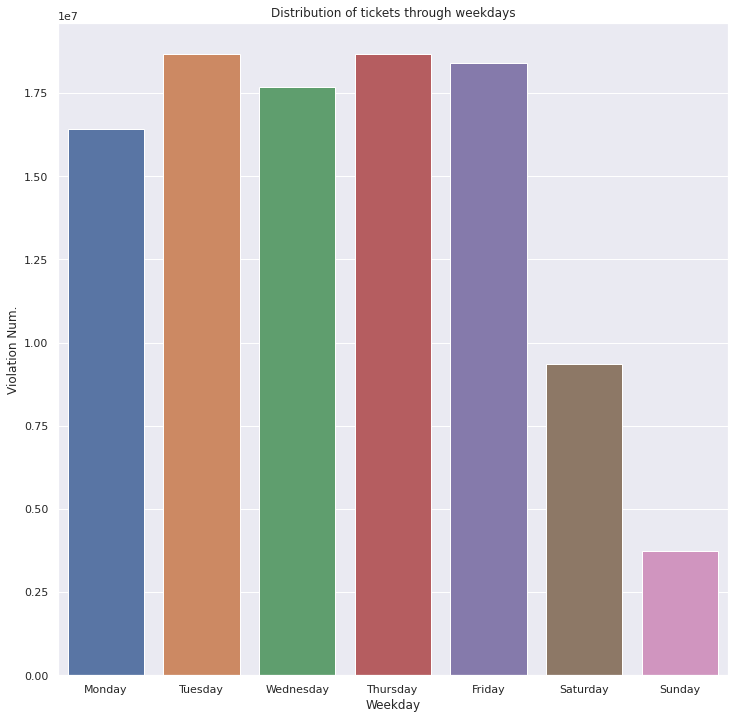

In [56]:
plt.figure(figsize=(12,12))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(data=df_c,x ='Weekday',y='Violation Num.', order = order).set(title="Distribution of tickets through weekdays")

In [21]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Vehicle Year'])
df_vehicle_body_type = df["Vehicle Year"].dropna().value_counts()
df_vehicle_body_type = df_vehicle_body_type.to_frame("Violation Num.")
df_vehicle_body_type["Vehicle Year"] = df_vehicle_body_type.index
df_vehicle_body_type = df_vehicle_body_type.reset_index()[["Vehicle Year", "Violation Num."]]
df_c = df_vehicle_body_type.compute().drop([0])

CPU times: user 147 ms, sys: 35.7 ms, total: 183 ms
Wall time: 4.26 s


[Text(0.5, 1.0, 'Distribution of vehicle years')]

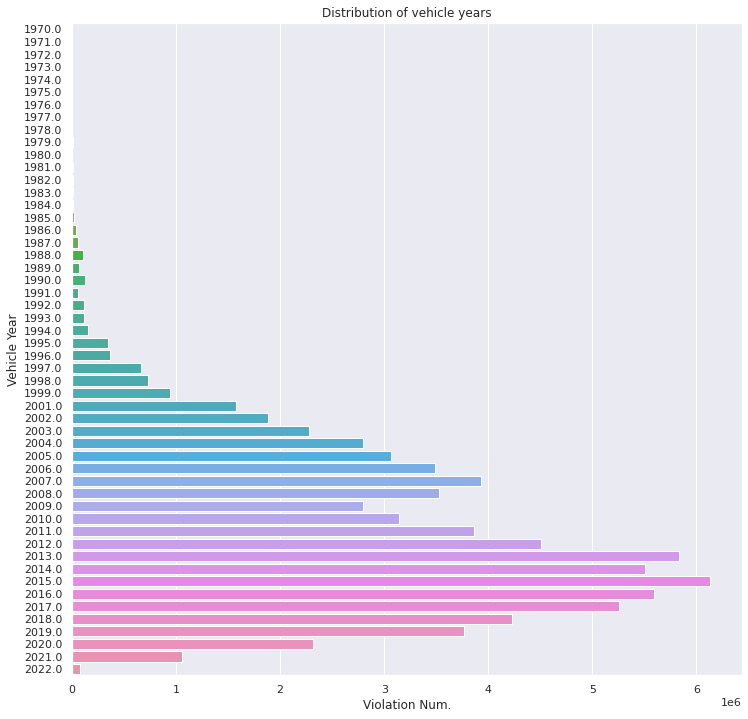

In [29]:
df_c = df_c[df_c["Vehicle Year"] < 2023]
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,y ='Vehicle Year',x='Violation Num.', orient="h").set(title='Distribution of vehicle years')

In [45]:
%%time
county_map = {'BX':'BRONX', 
                'BRONX':'BRONX',
                'MN':'MANHATTAN',
                'M':'MANHATTAN',
                'NY':'MANHATTAN',
                'MAN':'MANHATTAN',
                'NEWY':'MANHATTAN',
                'MH':'MANHATTAN',
                'NYC':'MANHATTAN',
                'NEW Y':'MANHATTAN',
                'BK':'BROOKLYN',
                'K':'BROOKLYN',
                'K F':'BROOKLYN',
                'KINGS':'BROOKLYN',
                'KING':'BROOKLYN',
                'Q':'QUEENS',
                'QU':'QUEENS',
                'QN':'QUEENS',
                'QNS':'QUEENS',
                'QUEEN':'QUEENS',
                'ST':'STATEN ISLAND',
                'R':'STATEN ISLAND',
                'RICH':'STATEN ISLAND',
                'P':'OTHER',
                '103':'OTHER',
                'RC':'OTHER',
                'QU':'QUEENS',
                '00000':'OTHER',
                'PBX':'OTHER',
                'USA':'OTHER',
                'K   F':'BROOKLYN',
                'A':'OTHER',
                'F':'OTHER',
                'Qns':'QUEENS',
                'Bronx':'BRONX',
                'Kings':'BROOKLYN',
                'Rich':'STATEN ISLAND',
                '': 'OTHER'

}
df = dd.read_parquet(PARQUET_PATH, columns=['Violation County'])
df['Violation County'] = df['Violation County'].fillna('P')
df[["County"]] = df[["Violation County"]].replace(to_replace= county_map)
#df.head(3)

df_violation_county = df['County'].value_counts()
df_violation_county = df_violation_county.to_frame("Violation Num.")
df_violation_county['County'] = df_violation_county.index
df_violation_county = df_violation_county.reset_index()[['County', "Violation Num."]]
df_c = df_violation_county.compute()
#df_c.head(3)

CPU times: user 2.63 s, sys: 452 ms, total: 3.08 s
Wall time: 53.3 s


In [46]:
df_c.head(3)

,County,Violation Num.
0,MANHATTAN,93919357
1,BROOKLYN,39402830
2,QUEENS,32844484


[Text(0.5, 1.0, 'Distribution of tickets per County')]

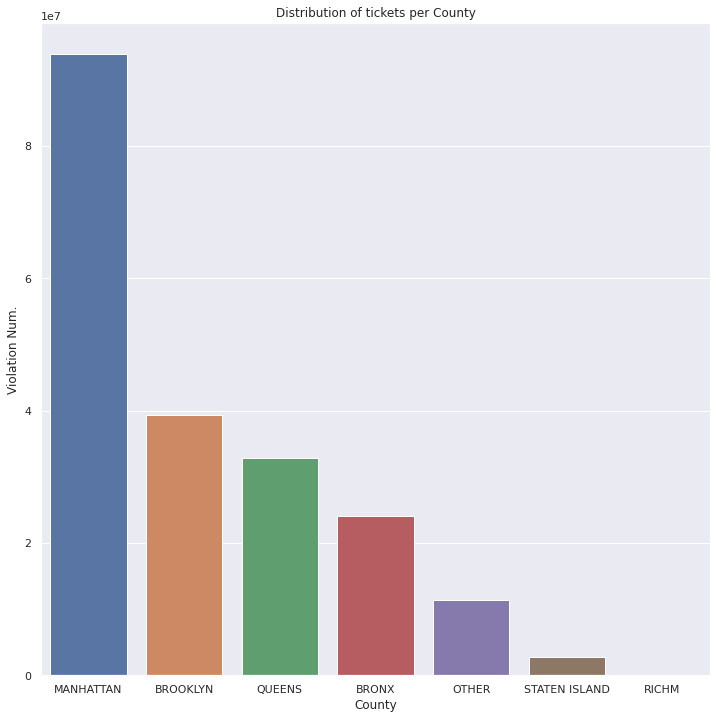

In [47]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='County',y='Violation Num.').set(title="Distribution of tickets per County")

In [35]:
df_c.head(3)

,County,Violation Num.
0,NY,31761444
1,K,19018368
2,Q,17090640


In [53]:
!pip install plotly.express
!pip install plotly.io

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.2 MB 8.2 kB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io


In [54]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Registration State'])
df_violation_county = df['Registration State'].value_counts()
df_violation_county = df_violation_county.to_frame("Violation Num.")
df_violation_county['Registration State'] = df_violation_county.index
df_violation_county = df_violation_county.reset_index()[['Registration State', "Violation Num."]]
df_c = df_violation_county.compute()
df_c.head(3)

,Registration State,Violation Num.
0,NY,79465913
1,NJ,9363215
2,PA,2798648


In [57]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

fig = px.choropleth(df_c,
                    locations='Registration State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Violation Num.',
                    color_continuous_scale="Viridis_r"
                    )
fig.show()

In [95]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Violation County', 'Vehicle Year'])
df = df[df["Vehicle Year"] != 0]
df['Violation County'] = df['Violation County'].fillna('P')
df[["County"]] = df[["Violation County"]]
df["Violation Num."] = 1
df = df.groupby(['County', 'Vehicle Year']).sum()
#df = df.compute()
#df['Violation County'] = list([df.index[i][0] for i in range(len(df.index))])
#df['Vehicle Year'] = list([df.index[i][1] for i in range(len(df.index))])
#df = df.reset_index()[['Registration State', "Violation Num."]]

df = df.reset_index()
df[["County"]] = df[["County"]].replace(to_replace= county_map)
df = df.groupby(['County', 'Vehicle Year']).sum()

df_c = df.compute()
df_c.head(3)

CPU times: user 861 ms, sys: 299 ms, total: 1.16 s
Wall time: 26.5 s


Violation Num.
County Vehicle Year                
BRONX  1970.0                   131
       1971.0                   163
       1972.0                   159

In [96]:
df_c = df_c.reset_index()

In [91]:
df_c.head(3)

,County,Vehicle Year,c
0,BRONX,1970.0,131
1,BRONX,1971.0,163
2,BRONX,1972.0,159


[Text(0.5, 1.0, 'Scatter plot for counties and vehicle years')]

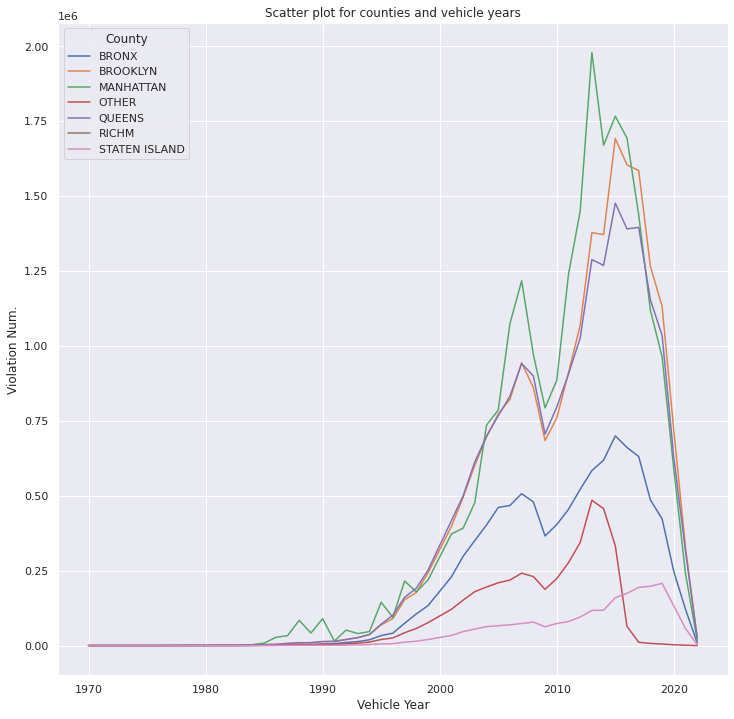

In [97]:
df_c = df_c[df_c["Vehicle Year"] < 2023]
plt.figure(figsize=(12,12))
sns.lineplot(data=df_c, x='Vehicle Year', y="Violation Num.", hue='County').set(title="Scatter plot for counties and vehicle years")

In [85]:
%%time

def get_hour(df):
    time_str = df["Violation Time"]
    try:
        add = 0
        if time_str[-1] == "P" and int(time_str[:2]) != 12:
            add = 12
        return int(time_str[:2]) + add 
        
    except:
        return None

df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Violation Time'])
#df['Date']=dd.to_datetime(df['Violation Time'])
#df['Weekday'] = df['Date'].dt.day_name()
df['Hour'] = df.apply(get_hour, axis=1, result_type="expand")
#df['c'] = 1
df_hour = df["Hour"].value_counts()
df_hour = df_hour.to_frame("Violation Num.")
df_hour["Hour"] = df_hour.index
df_hour = df_hour.reset_index()[["Hour", "Violation Num."]]
df_c = df_hour.compute()
#df_c = df.compute()
df_c.head(3)

/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/dask/dataframe/core.py:4959: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


CPU times: user 24.6 s, sys: 9.41 s, total: 34 s
Wall time: 14min 28s


,Hour,Violation Num.
0,9.0,10416934
1,11.0,10251893
2,13.0,9858091


In [86]:
df_e = df_c
df_e["Hour"] = df_e["Hour"] % 24
df_e[df_e["Hour"] == 0] = 24
df_e = df_e.groupby("Hour").sum()
df_e.head(3)

,Violation Num.
Hour,
1.0,764842
2.0,639155
3.0,483935


[Text(0.5, 1.0, 'Distribution of tickets per hour')]

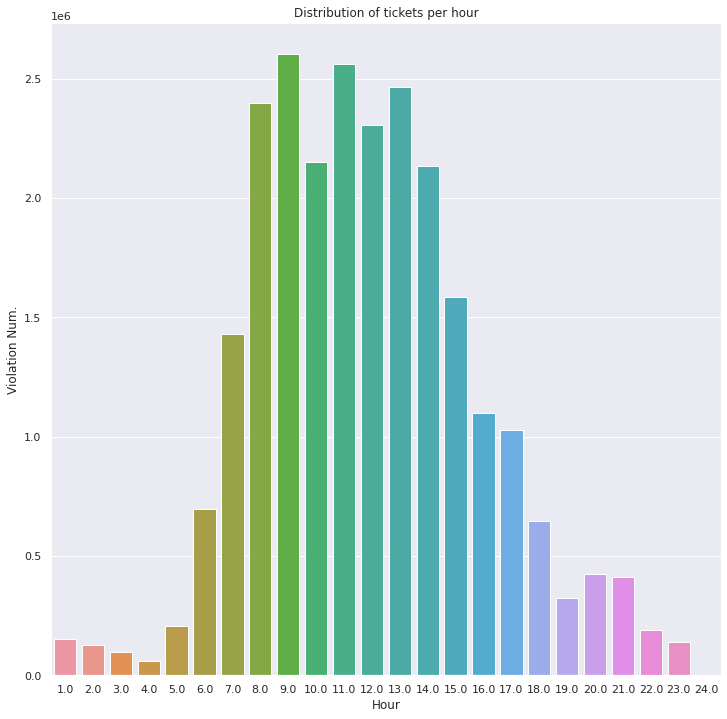

In [87]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='Hour',y='Violation Num.', ci=None).set(title="Distribution of tickets per hour")

In [79]:
df_e["Hour"].sum()

1063.0

In [81]:
df_e.groupby("Hour").sum().head(30)

,Violation Num.
Hour,
1.0,9858152
2.0,8547800
3.0,6340343
4.0,5506041
5.0,4105924
6.0,2584646
7.0,1299262
8.0,1696752
9.0,1645667


## Data Augmentation exploration

In [24]:
df = dd.read_parquet(PARQUET_PATH, columns = ["Street Name"])
df_sn = df["Street Name"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["Street Name"] = df_sn.index
df_sn = df_sn.reset_index()[["Street Name", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,Street Name,Violation Num.
0,BROADWAY,88549965
1,Broadway,1648999
2,3rd Ave,1206390


[Text(0.5, 1.0, 'Distribution of tickets per street')]

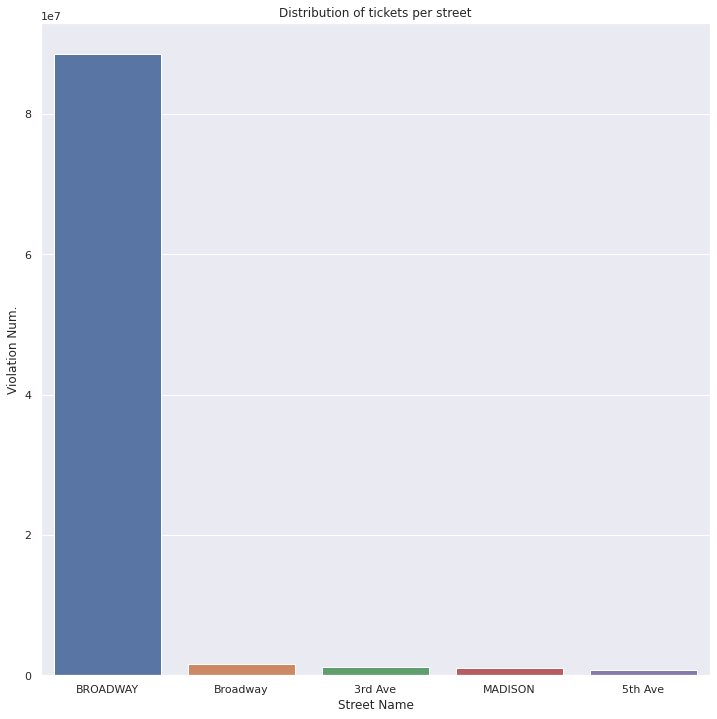

In [28]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c.nlargest(5,'Violation Num.'),x ='Street Name',y='Violation Num.').set(title="Distribution of tickets per street")

In [29]:
df = dd.read_parquet(PARQUET_PATH, columns = ["PoI"])
df_sn = df["PoI"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["PoI"] = df_sn.index
df_sn = df_sn.reset_index()[["PoI", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,PoI,Violation Num.
0,EL MOROCCO,928480
1,HENRY HUDSON PARKWAY OVER BDWY,812543
2,STRAUS PARK,812449


[Text(0.5, 1.0, 'Distribution of tickets per place of interest')]

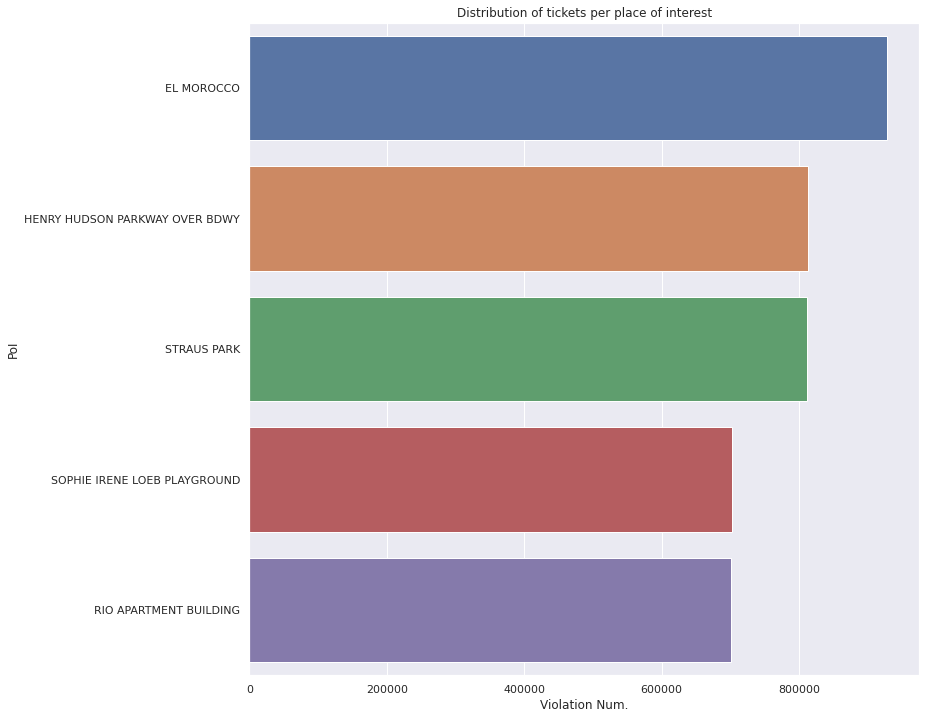

In [32]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c.nlargest(5,'Violation Num.'),y ='PoI',x='Violation Num.', orient ="h").set(title="Distribution of tickets per place of interest")

In [34]:
df = dd.read_parquet(PARQUET_PATH, columns = ["Elementary"])
df_sn = df["Elementary"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["Elementary"] = df_sn.index
df_sn = df_sn.reset_index()[["Elementary", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,Elementary,Violation Num.
0,"P.S. 145, The Bloomingdale School",3328062
1,Brooklyn Landmark Elementary School,2710232
2,P.S. 130 Hernando De Soto,2696873


[Text(0.5, 1.0, 'Distribution of tickets per elementary school')]

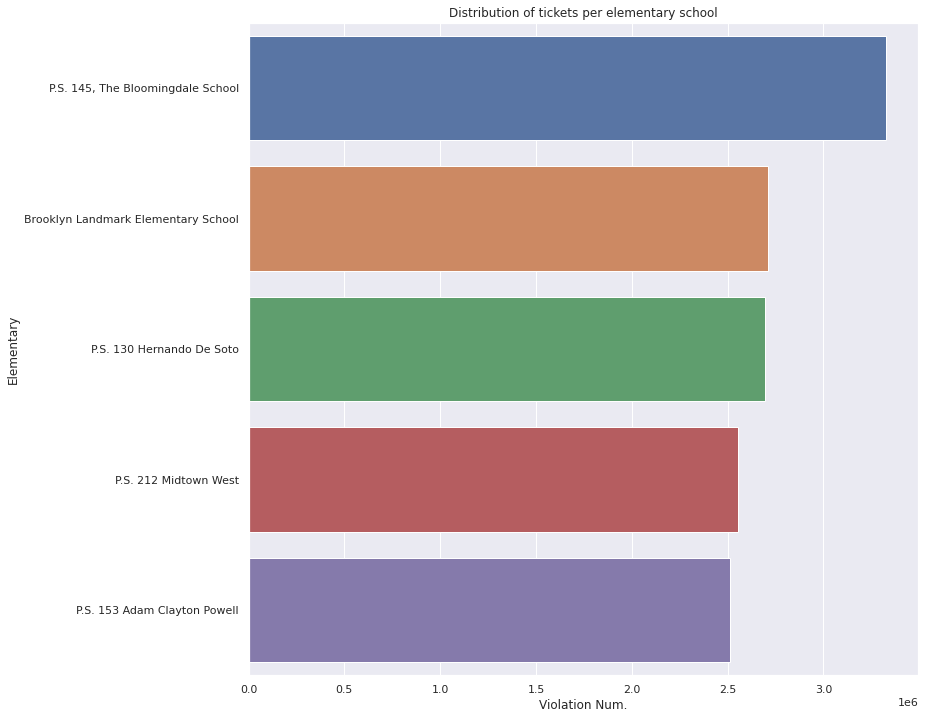

In [37]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c.nlargest(5,'Violation Num.'),y ='Elementary',x='Violation Num.', orient ="h").set(title="Distribution of tickets per elementary school")

In [38]:
df = dd.read_parquet(PARQUET_PATH, columns = ["High School"])
df_sn = df["High School"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["High School"] = df_sn.index
df_sn = df_sn.reset_index()[["High School", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,High School,Violation Num.
0,Gregorio Luperon High School for Science and M...,6371764
1,Edward A. Reynolds West Side High School,5489244
2,William Cullen Bryant High School,4644228


[Text(0.5, 1.0, 'Distribution of tickets per high school')]

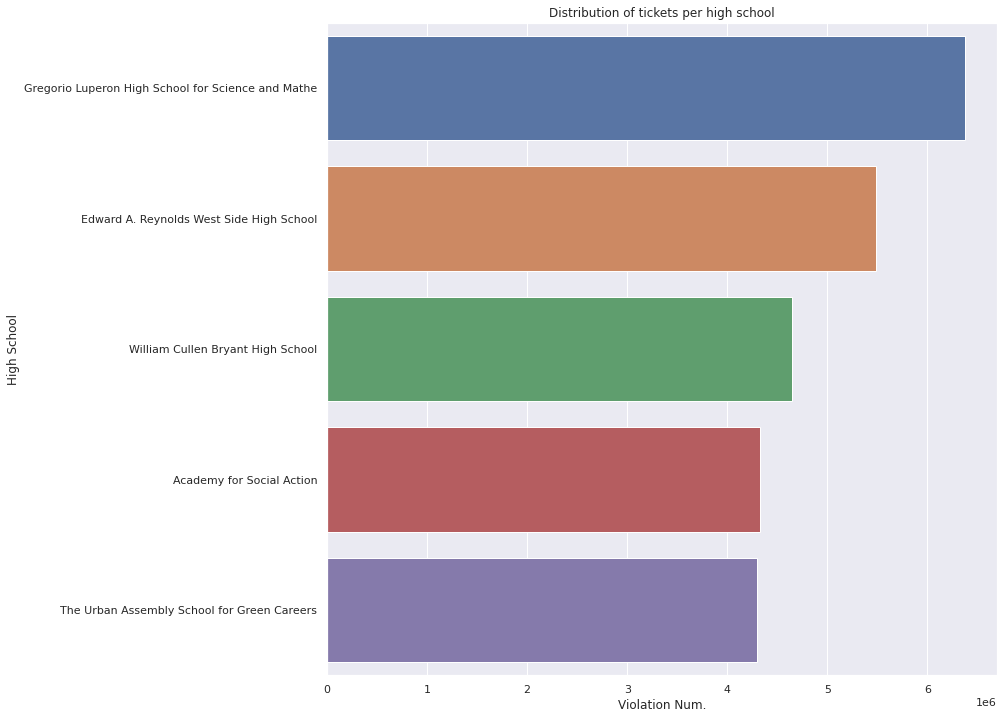

In [40]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c.nlargest(5,'Violation Num.'),y ="High School",x='Violation Num.', orient ="h").set(title="Distribution of tickets per high school")

In [41]:
df = dd.read_parquet(PARQUET_PATH, columns = ["AirTemp"])
df_sn = df["AirTemp"].round().value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["AirTemp"] = df_sn.index
df_sn = df_sn.reset_index()[["AirTemp", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,AirTemp,Violation Num.
0,83.0,1172894
1,72.0,1074802
2,77.0,1011021


[Text(0.5, 1.0, 'Scatter plot for (rounded) temperature and number of violations')]

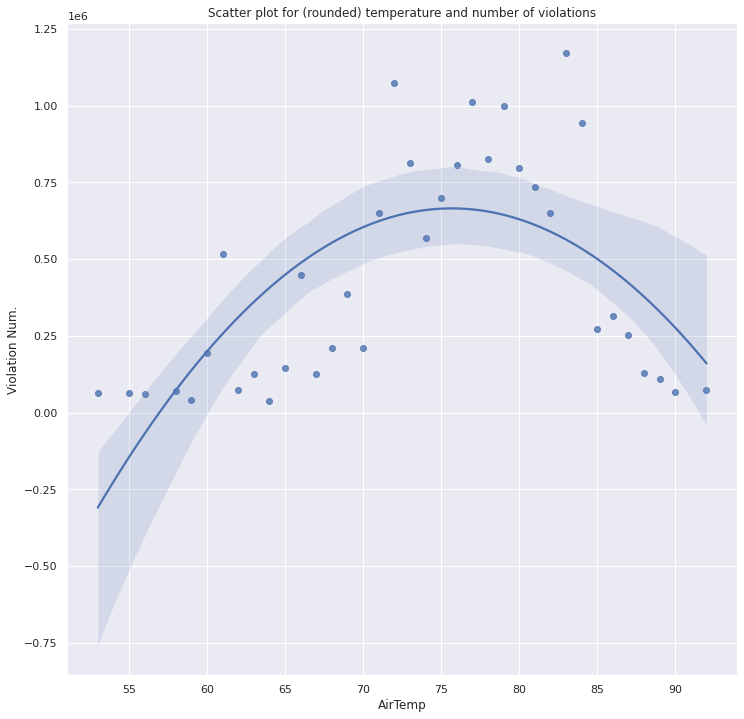

In [44]:
plt.figure(figsize=(12,12))
sns.regplot(data=df_c,x ="AirTemp",y='Violation Num.', order=2, scatter=True).set(title="Scatter plot for (rounded) temperature and number of violations")

In [95]:
df = dd.read_parquet(PARQUET_PATH, columns = ["Issue Date"])
df['Date']=dd.to_datetime(df['Issue Date'])
df["Year"] = df["Date"].dt.year
df_sn = df["Year"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["Year"] = df_sn.index
df_sn = df_sn.reset_index()[["Year", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,Year,Violation Num.
0,2021.0,15005328
1,2020.0,13082155
2,2019.0,12775814


[Text(0.5, 1.0, 'Distribution of tickets per street')]

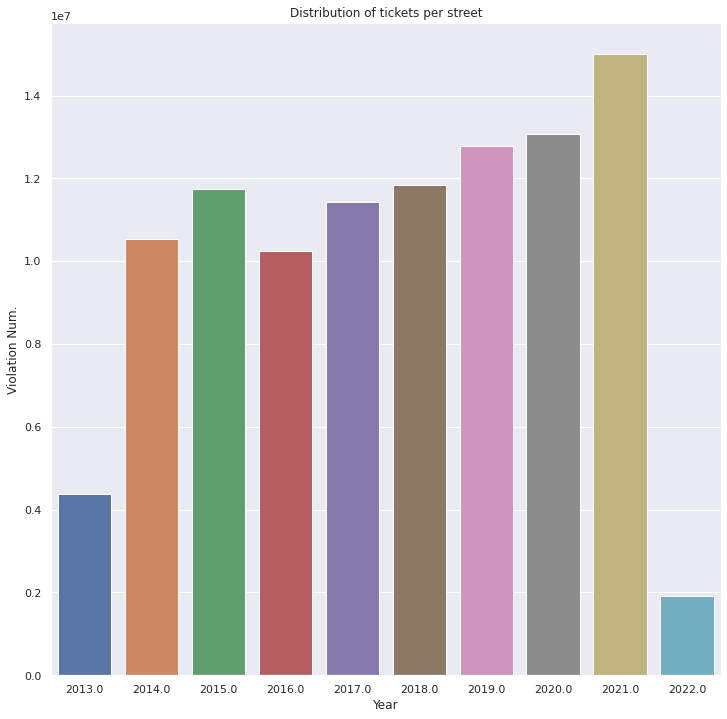

In [96]:
df_c = df_c[(df_c["Year"] < 2023) & (df_c["Year"] > 2012) ]
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='Year',y='Violation Num.').set(title="Distribution of tickets per street")

In [58]:
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns = ["Issue Date"])
df['Date']=dd.to_datetime(df['Issue Date'])
df["Year"] = df["Date"].dt.year
df_sn = df["Year"].value_counts()
df_sn = df_sn.to_frame("Violation Num.")
df_sn["Year"] = df_sn.index
df_sn = df_sn.reset_index()[["Year", "Violation Num."]]
df_c = df_sn.compute()
df_c.head(3)

,Year,Violation Num.
0,2021.0,15005328
1,2020.0,13082155
2,2019.0,12775814


[Text(0.5, 1.0, 'Distribution of tickets per street')]

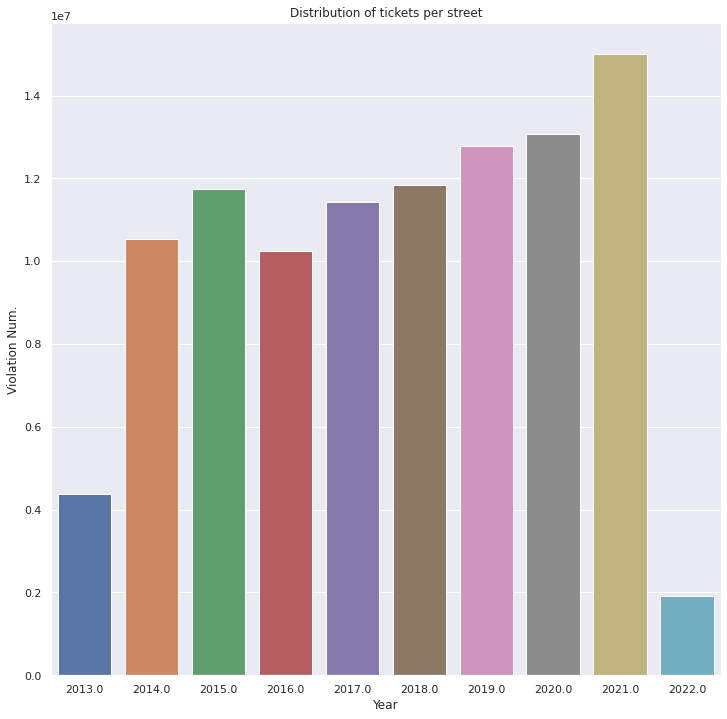

In [59]:
df_c = df_c[(df_c["Year"] < 2023) & (df_c["Year"] > 2012) ]
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='Year',y='Violation Num.').set(title="Distribution of tickets per street")

In [84]:
s = set()
for f in files:
    df = dd.read_csv("/d/hpc/projects/FRI/bigdata/data/NYTickets/" + f, dtype=col_types_2)
    print(df.columns)
    print(len(df.columns))
    s.update(list(df.columns.values))
    print("=====")
print(len(s))

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'Number', 'Street',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')
43
=====
Index(['S

In [86]:
new_cols = {}
for f in files:
    df = dd.read_csv("/d/hpc/projects/FRI/bigdata/data/NYTickets/" + f, dtype=col_types_2)
    new_cols[f] = list(s - set(df.columns.values))
print(new_cols)

{'2014.csv': ['Street Name', 'Days Parking In Effect', 'House Number'], '2015.csv': ['Street', 'Days Parking In Effect', 'Number'], '2016.csv': ['Street', 'Days Parking In Effect', 'Number'], '2017.csv': ['Street', 'Days Parking In Effect', 'Number'], '2018.csv': ['Street', 'Days Parking In Effect', 'Number'], '2019.csv': ['Street', 'Days Parking In Effect    ', 'Number'], '2020.csv': ['Street', 'Days Parking In Effect    ', 'Number'], '2021.csv': ['Street', 'Days Parking In Effect    ', 'Number'], '2022.csv': ['Street', 'Days Parking In Effect', 'Number']}


In [69]:
print(df_c[df_c["Year"] == 2022])

     Year  Violation Num.
9  2022.0         2883999


In [66]:
print(df_c[df_c["Year"] == 2022])

     Year  Violation Num.
9  2022.0         1918027


## Machine Learning

In [108]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import streamz
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import csv
from tqdm import tqdm

from pyarrow import dataset as ds
import os
import numpy as np
import pandas as pd

import dask_jobqueue
import dask
import dask.dataframe as dd
import time

from distributed import Client
from contextlib import suppress 
import platform; print( platform.python_version () )

3.9.7


In [109]:
PARQUET_PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/parquet"

In [118]:
def start_stream(sources, stream):
    stream.start()
    for j in sources:
        df = dd.read_parquet(j)
        #ddf = dd.from_pandas(df, npartitions=2)
        for _,r in df.iterrows():
            print(r)
            stream.emit(r)
        break

In [119]:
from streamz import Stream
import re
import glob
from streamz.dataframe import DataFrame
import matplotlib.pyplot as plt

stream = Stream(asynchronous=False)



df = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet/part.0.parquet')


start_stream(sources, stream)
sdf = DataFrame(stream, example= df.head(1))
sdf.tail()

MemoryError: 

In [162]:
source = Stream.filenames('/d/hpc/projects/FRI/bigdata/students/mfmt/parquet/part.0.parquet')  # stream of filenames
sdf = (source.map(pd.read_parquet).to_dataframe(example=df.head(1)))        # logical streaming dataframe

sdf.stream.sink(print)  

KeyboardInterrupt: 

In [160]:
source.start()

In [161]:
source.stop()

In [154]:
type(sdf)

streamz.core.map

In [163]:
import pandas as pd
from streamz import Stream
from streamz.dataframe import DataFrame
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import toolz
import random
from datetime import datetime
from scipy.spatial import distance

In [171]:
source = Stream()

sources = glob.glob(PARQUET_PATH+"/*.parquet")
sources.sort(key=lambda f: int(re.sub('\D', '', f)))
df = pd.read_parquet(sources[0], columns=['Registration State'])
print("lala")
sdf = DataFrame(stream = source, example= df.head(1))

d = {}

def stest(r):
    s_name = str(r['Registration State'])
    if s_name in d:
        d[s_name] = d[s_name] + 1
    else:
        d[s_name] = 1
    

sdf.stream.sink(stest)

for j in sources:
    df = pd.read_parquet(j, columns=['Registration State'])
    print(j)
    for i in range(len(df)):
        source.emit(df.iloc[i])
        print(sdf.tail(5))
        continue
        if i%1000==0:
            clear_output(wait=True)
            plt.clf()
            tmp = d.copy()
            #tmp.pop('Unknown', None)
            data = dict(sorted(tmp.items(), key=lambda item: item[1], reverse=True)[:6])
            plt.barh(range(len(data)), list(data.values()), tick_label=list(data.keys()))
            plt.show()
            print("{2}\n{0}/{1}".format(i, len(df), j))

lala
/d/hpc/projects/FRI/bigdata/students/mfmt/parquet/part.0.parquet
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State


0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__                   
0                                   NY
DataFrame - elements like:
                    Registration State
__null_dask_index__            

KeyboardInterrupt: 